## Hands-on 10: Classificação de imagens (Flowers)

Baseado nesse artigo: https://towardsdatascience.com/flower-classification-with-convolutional-neural-networks-b97130329e5f

### Montando o drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Imports das bibliotecas

In [ ]:
!pip install keras

In [ ]:
import os
import cv2
import random
from os import listdir
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### Caminho do dataset

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/flowers'
categories = ['tulip', 'dandelion', 'daisy', 'rose', 'sunflower']

### Carregando o nome dos arquivos


In [ ]:
fnames = []
for category in categories:
    flower_folder = os.path.join(path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print(f'Tamanho para cada categoria: {[len(f) for f in fnames]}')

Tamanho para cada categoria: [984, 1055, 769, 784, 734]


### Carregando os arquivos

In [ ]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

print(f'Número de imagens para cada categoria: {[len(f) for f in fnames]}')

Número de imagens para cada categoria: [984, 1055, 769, 784, 734]


### Exemplo das imagens

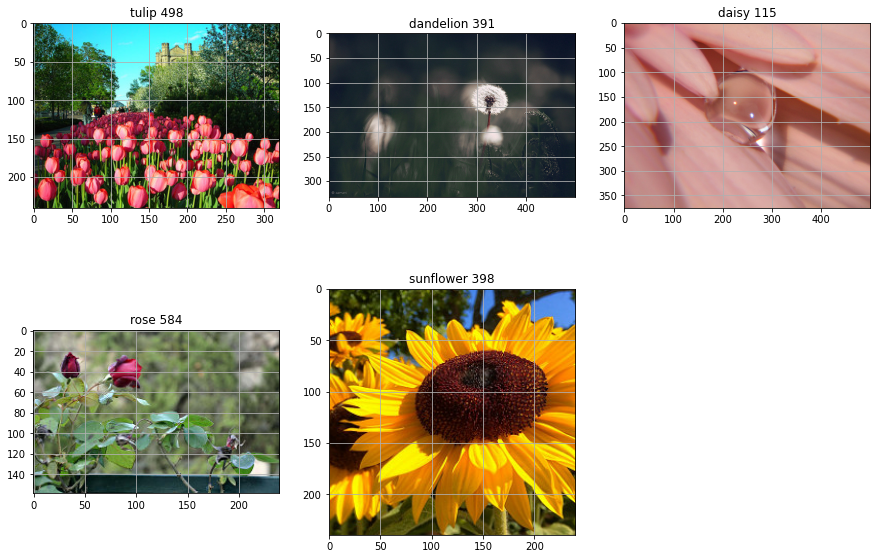

In [ ]:
plt.figure(figsize=(15, 10))

for i, imgs in enumerate(images):
    plt.subplot(2, 3, i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cv2.cvtColor(imgs[idx], cv2.COLOR_BGR2RGB))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

### Redimensionamento das imagens

In [ ]:
resized_images = []
img_width, img_height = 144, 144

for i, imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

### Separação dos dados


In [ ]:
from sklearn.model_selection import train_test_split

train_images = []
val_images = []

for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

### Gerando os rótulos

In [ ]:
len_train_images = [len(imgs) for imgs in train_images]
print('Soma das imagens de treino:', np.sum(len_train_images))

train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')

for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

Soma das imagens de treino: 3457


In [ ]:
len_val_images = [len(imgs) for imgs in val_images]
print('Soma das imagens de teste:', np.sum(len_val_images))

val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')

for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

Soma das imagens de teste: 866


### Converte os dados em matriz numpy

In [ ]:
tmp_train_imgs = []
tmp_val_imgs = []

for imgs in train_images:
    tmp_train_imgs += imgs

for imgs in val_images:
    tmp_val_imgs += imgs
    
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [ ]:
from tensorflow.python.keras.utils import np_utils

train_data = train_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))

val_data = val_images.astype('float32')
val_labels = np_utils.to_categorical(val_categories, len(categories))

print(f'Train data: {train_data.shape}')
print(f'Train labels: {train_labels.shape}')

Train data: (3457, 144, 144, 3)
Train labels: (3457, 5)


### Embaralhando a base de dados

In [ ]:
seed = 100
np.random.seed(seed)

np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

X_train = train_data[:3400]
y_train = train_labels[:3400]
X_test = val_data[:860]
y_test = val_labels[:860]

### Normalização dos dados

In [ ]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
X_train[0][0][:5]

array([[0.14117648, 0.76862746, 0.9019608 ],
       [0.12941177, 0.76862746, 0.8980392 ],
       [0.12941177, 0.7764706 , 0.90588236],
       [0.13333334, 0.78039217, 0.9098039 ],
       [0.13333334, 0.7882353 , 0.91764706]], dtype=float32)

### Implementação da Rede

In [ ]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=train_data.shape[1:]))
model.add(Activation('relu'))
BatchNormalization(axis=1)
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
BatchNormalization(axis=1)
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
BatchNormalization(axis=1)
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 140, 140, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 140, 140, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 138, 138, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 138, 138, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 67, 67, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 67, 67, 64)        0

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

### Data Augmentation


In [ ]:
batch_size = 128
epochs = 50

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.06, 
    shear_range=0.9,
    height_shift_range=0.3, 
    zoom_range=0.3
)

train_gen.fit(X_train)
train_generator = train_gen.flow(X_train, y_train, batch_size=batch_size)
print('Number of examples:', train_generator.n)

Number of examples: 3400


In [ ]:
test_gen = ImageDataGenerator()
test_generator = test_gen.flow(X_test, y_test, batch_size=batch_size)

### Modelo


In [ ]:
from keras.callbacks import TensorBoard, EarlyStopping
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Linha necessária para funcionar o TensorBoard
tbCallBack = TensorBoard(log_dir='logs_lab09', histogram_freq=0, write_graph=True, write_images=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import time
start = time.time()

model_cnn = model.fit(train_generator,
                      steps_per_epoch= X_train.shape[0]//batch_size, 
                      epochs = epochs,
                      validation_data=test_generator, 
                      validation_steps=y_test.shape[0]//batch_size,
                      callbacks=[EarlyStopping(patience=3),tbCallBack])

end = time.time()
print(f'Duração em minutos: {(end - start)/60}')

Epoch 1/50
26/26 [==============================] - 14s 536ms/step - loss: 0.6701 - accuracy: 0.7549 - val_loss: 0.6448 - val_accuracy: 0.7500
Epoch 2/50
26/26 [==============================] - 14s 537ms/step - loss: 0.6573 - accuracy: 0.7515 - val_loss: 0.8555 - val_accuracy: 0.7057
Epoch 3/50
26/26 [==============================] - 14s 542ms/step - loss: 0.6573 - accuracy: 0.7479 - val_loss: 0.7423 - val_accuracy: 0.7201
Epoch 4/50
26/26 [==============================] - 14s 539ms/step - loss: 0.6209 - accuracy: 0.7714 - val_loss: 0.6978 - val_accuracy: 0.7461
Duração em minutos: 0.9927361130714416


### Avaliação do modelo

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

27/27 [==============================] - 0s 15ms/step - loss: 0.7028 - accuracy: 0.7419

Test loss: 0.7027924060821533
Test accuracy: 0.7418604493141174


### Performance

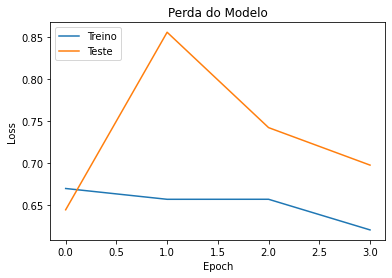

In [ ]:
plt.plot(model_cnn.history['loss'])
plt.plot(model_cnn.history['val_loss'])
plt.title('Perda do Modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'upper left')
plt.show()

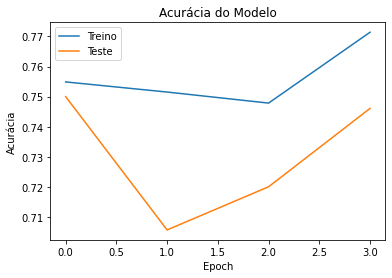

In [ ]:
plt.plot(model_cnn.history['accuracy'])
plt.plot(model_cnn.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'upper left')
plt.show()

### Predição

In [ ]:
pred = model.predict(X_test)

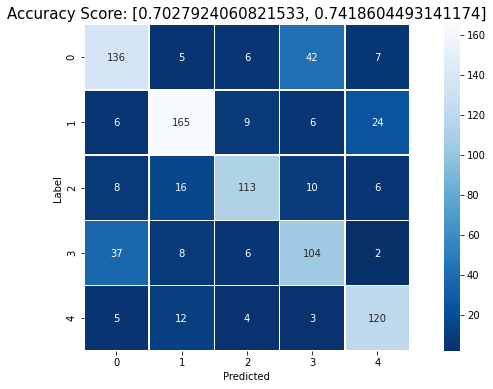

In [ ]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Label');
plt.xlabel('Predicted');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Salva o modelo

In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/modelo_lab10.h5')

### Resultado

In [ ]:
import pandas as pd

dic = {
    'rotation_range' : [6, 10, 10], 
    'width_shift_range' : [0.03, 0.06, 0.09], 
    'shear_range' : [0.7, 0.9, 0.9],
    'height_shift_range' : [0.1, 0.3, 0.7], 
    'zoom_range' : [0.1, 0.3, 0.7],
    'time (min)': [4.39, 0.99, 2.04],
    'accuracy': [0.691, 0.741, 0.709]
}

res = pd.DataFrame(data=dic)
res.sort_values(['accuracy'], ascending=False)

,rotation_range,width_shift_range,shear_range,height_shift_range,zoom_range,time (min),accuracy
1,10,0.06,0.9,0.3,0.3,0.99,0.741
2,10,0.09,0.9,0.7,0.7,2.04,0.709
0,6,0.03,0.7,0.1,0.1,4.39,0.691
